Continuation of the testing notebook

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [19]:
def transform_board(image, rect):
    # Get the coordinates of the corners of the board
    x1, y1, x2, y2, x3, y3, x4, y4 = rect

    # Set the target size for the new image
    RESOLUTION_FACTOR = 8
    target_width = 112 * RESOLUTION_FACTOR
    target_height = 224 * RESOLUTION_FACTOR

    # Define the new coordinates of the corners in the new image
    new_rect = np.array([[0, 0], [target_width, 0], [target_width, target_height], [0, target_height]],
                        dtype=np.float32)

    # Calculate the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype=np.float32), new_rect)

    # Apply the perspective transformation to the original image
    transformed_image = cv2.warpPerspective(image, matrix, (target_width, target_height))

    return transformed_image

In [20]:
def show_im(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [21]:
def draw_circles(image, circles):
    if circles is not None:
        for i in circles:
            print(i)
            cv2.circle(image, (int(i[0]), int(i[1])), 20, (0, 255, 0), 3)
    return image

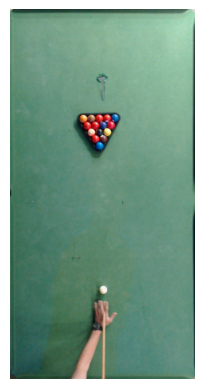

In [22]:

video_path = r"detect_objects_test_images\full_balls_no_green.mp4"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

rect = [72, 972, 105, 127, 1800, 152, 1817, 1005]
cropped_image = transform_board(frame, rect)
show_im(cropped_image)


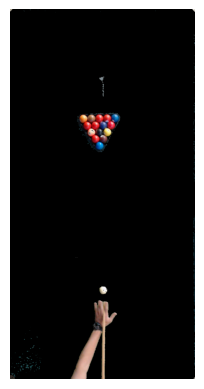

In [23]:
# remove green from the image
import copy


def remove_green(_image, new_color = [0, 0, 0]):
    image = copy.deepcopy(_image)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 0, 0])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    image[mask == 255] = new_color
    return image



show_im(remove_green(cropped_image))

In [24]:
image = remove_green(cropped_image)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
value = 42  #whatever value you want to add
hsv[:, :, 2] = 150
image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
cv2.imwrite('testyaala.png', image)

True

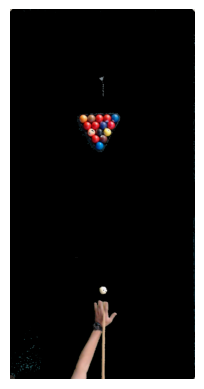

True

In [25]:
# for every white pixel, set the pixel to the average of the surrounding pixels
def remove_white(image):
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if np.linalg.norm(image[i, j]) >= 200:
                image[i, j] = image[i - 1:i + 2, j - 1:j + 2].mean(axis=(0, 1))
    return image


import copy

no_green_copy = copy.deepcopy(remove_green(cropped_image))
white_removed = remove_white(no_green_copy)
show_im(white_removed)
cv2.imwrite("blah.jpg", white_removed)

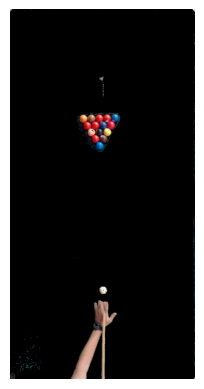

True

In [26]:
# apply bilateral filter
def bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 1, 200)


after_bilat = bilateral_filter(white_removed)
show_im(after_bilat)
cv2.imwrite("bilateral.jpg", after_bilat)


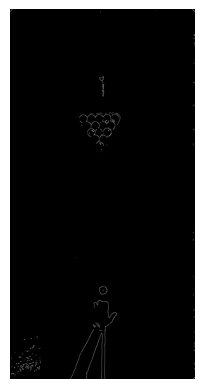

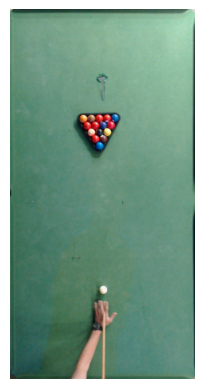

In [27]:
# apply canny edge detection
def canny_edge_detection(image):
    return cv2.Canny(image, 300, 400)


after_canny = canny_edge_detection(after_bilat)
show_im(canny_edge_detection(after_bilat))
cv2.imwrite("canny.jpg", after_canny)
show_im(cropped_image)


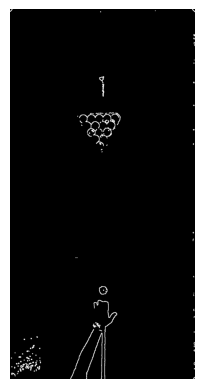

In [28]:
# dilate the edges
def dilate_edges(image):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.dilate(image, kernel, iterations=1)


after_dilate = dilate_edges(after_canny)
show_im(after_dilate)

In [29]:
def hough_circles(image, min_radius, max_radius, min_dist, param1, param2):
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1.5, min_dist, param1=param1, param2=param2,
                               minRadius=min_radius, maxRadius=max_radius)
    return circles


def find_balls(image, new_color=[0,0,0], return_intermediates=False):
    # Remove green from the image
    no_green_ = remove_green(image, new_color=new_color)
    # Remove white pixels
    # Define a threshold for "grayish" tones
    
    # Apply bilateral filter
    bilat_ = bilateral_filter(no_green_)
    # Apply canny edge detection
    canny_ = canny_edge_detection(bilat_)
    # Apply hough circles
    circles = hough_circles(canny_, 15, 30, 20, 50, 30)
    # return only the xy coordinates of the circles:
    if circles is not None:
        circles = circles[0, :][:, :2]
        circles = np.unique(circles, axis=0)

    if return_intermediates:
        # Return the intermediate results and the final circles
        fig, ax = plt.subplots(1, 4, figsize=(20, 10))
        ax[0].imshow(cv2.cvtColor(no_green_, cv2.COLOR_BGR2RGB))
        ax[0].axis('off')
        ax[0].set_title("No green")
        ax[1].imshow(cv2.cvtColor(bilat_, cv2.COLOR_BGR2RGB))
        ax[1].axis('off')
        ax[1].set_title("Bilateral filter")
        ax[2].imshow(canny_, cmap='gray')
        ax[2].axis('off')
        ax[2].set_title("Canny edge detection")
        balls = find_balls(image, new_color=[0, 255, 0])
        ax[3].imshow(draw_circles(image, balls), cmap='gray')
        ax[3].axis('off')
        ax[3].set_title("Hough circles")
        
        # make the plot a numpy image
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return data, circles
    else:
        return circles

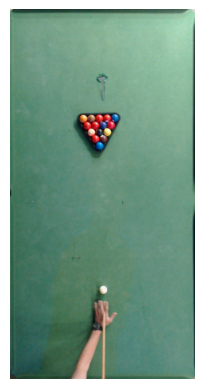

[[  78.75 1743.75]
 [ 354.75  528.75]
 [ 392.25  597.75]
 [ 393.75  531.75]
 [ 413.25  564.75]
 [ 429.75  531.75]
 [ 434.25  660.75]
 [ 450.75 1359.75]
 [ 467.25  597.75]
 [ 471.75  528.75]
 [ 488.25  561.75]
 [ 504.75  531.75]]
[  78.75 1743.75]
[354.75 528.75]
[392.25 597.75]
[393.75 531.75]
[413.25 564.75]
[429.75 531.75]
[434.25 660.75]
[ 450.75 1359.75]
[467.25 597.75]
[471.75 528.75]
[488.25 561.75]
[504.75 531.75]


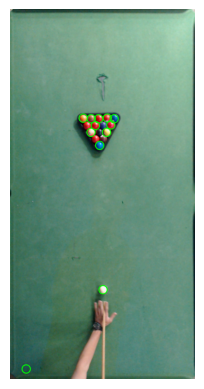

In [30]:
video_path = r"detect_objects_test_images\full_balls_no_green.mp4"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

rect = [72, 972, 105, 127, 1800, 152, 1817, 1005]
cropped_image = transform_board(frame, rect)

show_im(cropped_image)

circles = find_balls(cropped_image)

print(circles)
show_im(draw_circles(cropped_image, circles))

Test averageing frames

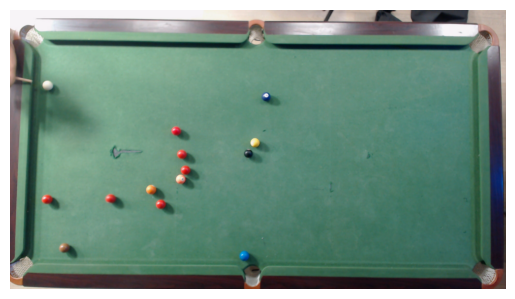

In [31]:
class FrameBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []

    def add_frame(self, frame):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(frame)

    def get_average_frame(self):
        if len(self.buffer) == 0:
            return None
        average_frame = np.zeros_like(self.buffer[0], dtype=np.float32)
        for frame in self.buffer:
            average_frame += frame
        average_frame /= len(self.buffer)
        average_frame = average_frame.astype(np.uint8)
        return average_frame

    def get_buffer(self):
        return self.buffer

video_path = r"detect_objects_test_images\full_balls_no_green.mp4"
cap = cv2.VideoCapture(video_path)

n = 5
buffer = FrameBuffer(n)
# skip the first 100 frames
for i in range(551):
    ret, frame = cap.read()

for i in range(n):
    ret, frame = cap.read()
    buffer.add_frame(frame)

show_im(buffer.get_average_frame())
test_frame = frame
cap.release()

[ 36.75 861.75]
[ 54.75 141.75]
[237.75 522.75]
[249.75  68.25]
[257.25 324.75]
[294.75 483.75]
[341.25 600.75]
[375.75 618.75]
[441.75 608.25]
[495.75 897.75]
[536.25 579.75]
[684.75 942.75]
[719.25  45.75]


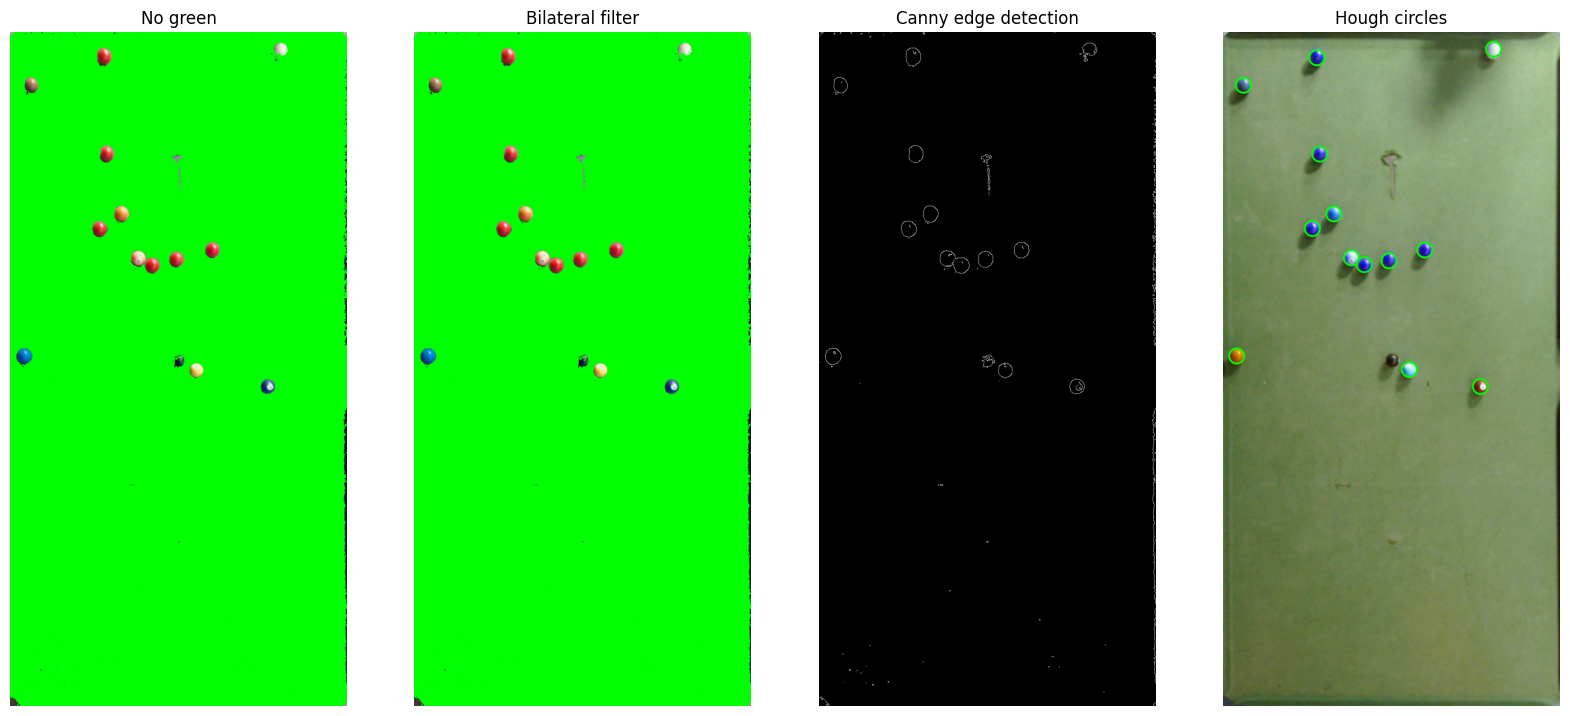

In [32]:
cropped_image = transform_board(test_frame, rect)
test_no_green = remove_green(cropped_image, new_color=[0, 255, 0])
test_bilat = bilateral_filter(test_no_green)
test_canny = canny_edge_detection(test_bilat)

# use matplotlib to show all the images side by side
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(test_no_green, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title("No green")
ax[1].imshow(cv2.cvtColor(test_bilat, cv2.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].set_title("Bilateral filter")
ax[2].imshow(test_canny, cmap='gray')
ax[2].axis('off')
ax[2].set_title("Canny edge detection")
balls = find_balls(cropped_image, new_color=[0, 255, 0])
ax[3].imshow(draw_circles(cropped_image, balls), cmap='gray')
ax[3].axis('off')
ax[3].set_title("Hough circles")
plt.show()

# save plot
fig.savefig("test_images.png")

In [33]:
# test the buffer
# cap = cv2.VideoCapture(video_path)

from perfectswish.api import webcam
cap = webcam.initialize_webcam(1)

buffer = FrameBuffer(5)

while True:
    frame = webcam.get_webcam_image(cap)
    rect = [72, 972, 105, 127, 1800, 152, 1817, 1005]
    cropped_image = transform_board(frame, rect)
    # transpose the image
    
    buffer.add_frame(cropped_image)
    average_frame = buffer.get_average_frame()
    if average_frame is not None:
        
        intermediate, circles = find_balls(average_frame, new_color=[0,255,0] ,return_intermediates=True)
        if circles is not None:
            average_frame = draw_circles(average_frame, circles)
        cv2.imshow("average_frame", intermediate)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

ImportError: cannot import name 'webcam' from 'perfectswish.api' (unknown location)

In [ ]:
cv2.destroyAllWindows()

# Finding the white ball specifically

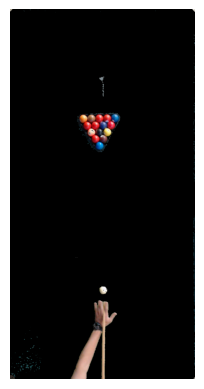

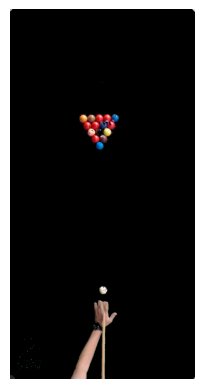

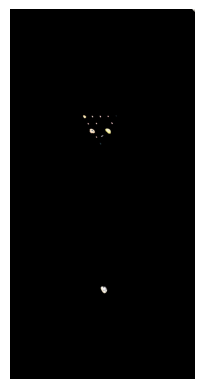

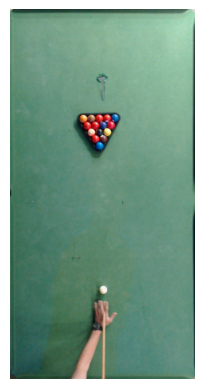

In [35]:
def find_white_ball(image):
    # Remove green from the image
    no_green_ = remove_green(image)
    show_im(no_green_)
    # Remove white pixels
    
    # Define a threshold for "grayish" tones
    threshold = 50
    
    # Calculate the absolute differences between the color channels
    diff_rg = np.abs(image[:, :, 0] - image[:, :, 1])
    # diff_rb = np.abs(image[:, :, 0] - image[:, :, 2])
    diff_gb = np.abs(image[:, :, 1] - image[:, :, 2])
    
    # Create a mask where all differences are below the threshold
    grayish_mask = (diff_rg < threshold) & (diff_gb < threshold) 
    grayish_only = no_green_
    grayish_only[grayish_mask] = 0
    show_im(grayish_only)
    norms = np.linalg.norm(no_green_, axis=2)
    mask = norms > 350
    white_only = no_green_
    white_only[~mask] = 0
    show_im(white_only)
    # Apply bilateral filter
    bilat_ = bilateral_filter(white_only)
    # Apply canny edge detection
    canny_ = canny_edge_detection(bilat_)
    # Apply hough circles
    circles = hough_circles(canny_, 15, 30, 20, 50, 30)
    # return only the xy coordinates of the circles:
    if circles is not None:
        circles = circles[0, :][:, :2]
        circles = np.unique(circles, axis=0)
    return circles

video_path = r"detect_objects_test_images\full_balls_no_green.mp4"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

rect = [72, 972, 105, 127, 1800, 152, 1817, 1005]
cropped_image = transform_board(frame, rect)
show_im(draw_circles(cropped_image, find_white_ball(cropped_image)))

cap.release()
